In [1]:
import pandas as pd
import os, glob
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import chi2_contingency, f_oneway
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_score, accuracy_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

## Data

In [2]:
directory = os.getcwd()

file_path = glob.glob(os.path.join(directory, "**/*healthcare-dataset-stroke-data.csv*"), recursive=True)
data = pd.read_csv(file_path[0])

data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# EDA

In [3]:
df_viz = data.copy()
df_viz['stroke'] = df_viz['stroke'].map({0: 'No Stroke', 1: 'Stroke'})

### Null Values

/var/folders/n3/fjyt97j951g_t23_1z8lwflw0000gn/T/ipykernel_3701/1406341596.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(non_null_counts.index, rotation=45, ha='right')


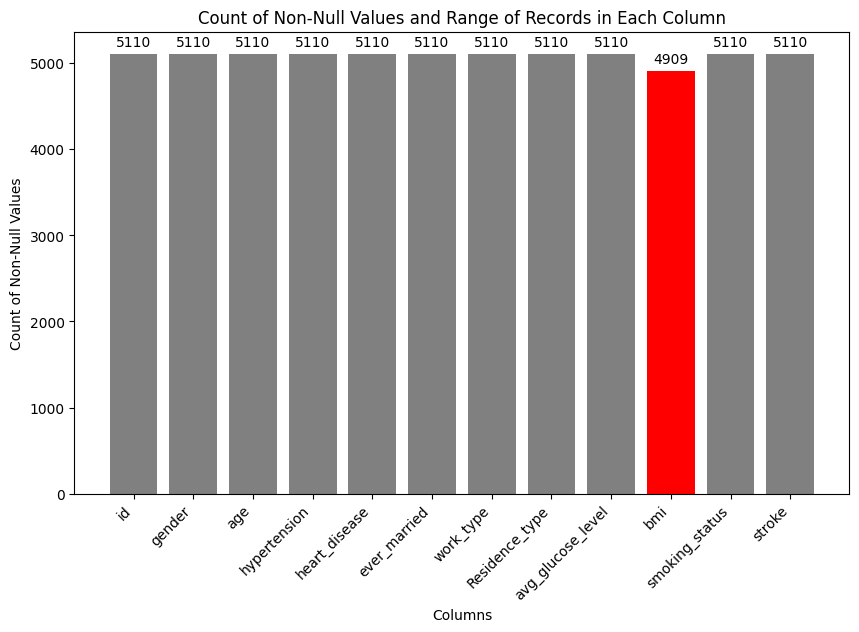

In [4]:
non_null_counts = data.notnull().sum()
total_records = len(data)

colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey','red','grey','grey']

# Plot the count of non-null values
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(non_null_counts.index, non_null_counts.values, color=colors)
ax.set_title('Count of Non-Null Values and Range of Records in Each Column')
ax.set_xlabel('Columns')
ax.set_ylabel('Count of Non-Null Values')
ax.set_xticklabels(non_null_counts.index, rotation=45, ha='right')  

# Add text annotations for count of non-null values
for bar, v in zip(bars, non_null_counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, v + 50, str(v), color='black', ha='center', va='bottom')

plt.show()


In [5]:
data = data.dropna()

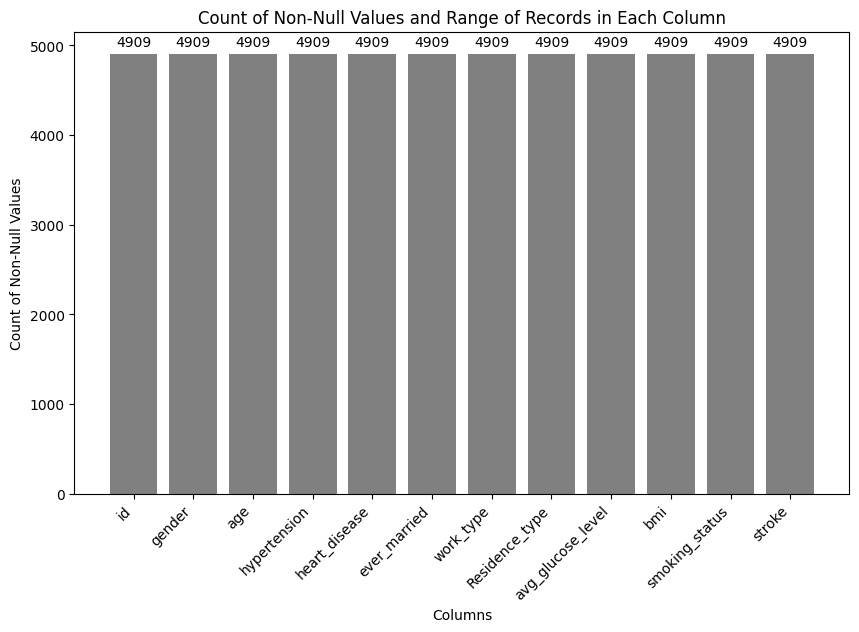

In [6]:
warnings.filterwarnings('ignore')
full_data = data.dropna().count()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(full_data.index, full_data.values, color='grey')
ax.set_title('Count of Non-Null Values and Range of Records in Each Column')
ax.set_xlabel('Columns')
ax.set_ylabel('Count of Non-Null Values')
ax.set_xticklabels(full_data.index, rotation=45, ha='right')  

for bar, v in zip(bars, full_data.values):
    ax.text(bar.get_x() + bar.get_width() / 2, v + 50, str(v), color='black', ha='center', va='bottom')

plt.show()

### Data Types

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4909 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4909 non-null   int64  
 1   gender             4909 non-null   object 
 2   age                4909 non-null   float64
 3   hypertension       4909 non-null   int64  
 4   heart_disease      4909 non-null   int64  
 5   ever_married       4909 non-null   object 
 6   work_type          4909 non-null   object 
 7   Residence_type     4909 non-null   object 
 8   avg_glucose_level  4909 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     4909 non-null   object 
 11  stroke             4909 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 498.6+ KB


In [8]:
bin_stats = data.describe(exclude=['object', 'float64']).round(2)
bin_stats

,id,hypertension,heart_disease,stroke
count,4909.00,4909.00,4909.00,4909.00
mean,37064.31,0.09,0.05,0.04
std,20995.10,0.29,0.22,0.20
min,77.00,0.00,0.00,0.00
25%,18605.00,0.00,0.00,0.00
50%,37608.00,0.00,0.00,0.00
75%,55220.00,0.00,0.00,0.00
max,72940.00,1.00,1.00,1.00


In [9]:
num_stats = data.describe(exclude=['object', 'int64']).round(2)
num_stats

,age,avg_glucose_level,bmi
count,4909.00,4909.00,4909.00
mean,42.87,105.31,28.89
std,22.56,44.42,7.85
min,0.08,55.12,10.30
25%,25.00,77.07,23.50
50%,44.00,91.68,28.10
75%,60.00,113.57,33.10
max,82.00,271.74,97.60


In [10]:
cat_stats = data.describe(exclude=['float64', 'int64']).round(2)
cat_stats

,gender,ever_married,work_type,Residence_type,smoking_status
count,4909,4909,4909,4909,4909
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2897,3204,2811,2490,1852


### Unique values for non-continuous numerical features

In [11]:
tmp = data.drop(columns=['age', 'avg_glucose_level', 'bmi', 'id'])
for column in tmp.columns:
    print(f"{column}: {tmp[column].unique()}")

gender: ['Male' 'Female' 'Other']
hypertension: [0 1]
heart_disease: [1 0]
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke: [1 0]


### Stroke vs. No Stroke

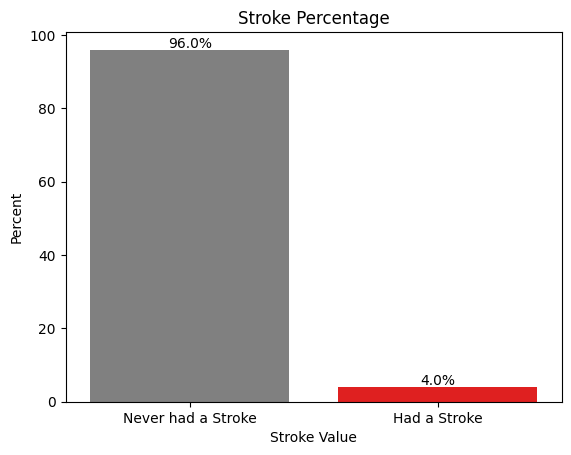

In [12]:
warnings.filterwarnings('ignore')
color_plt = ['Grey', 'Red']
tmp_data = data.copy()
tmp_data['stroke'] = tmp_data['stroke'].map({0:'Never had a Stroke', 1:'Had a Stroke'})
total_strokes = len(tmp_data)
stroke_counts = tmp_data['stroke'].value_counts()

stroke_percentages = round((stroke_counts / total_strokes) * 100, 0)

ax = sns.barplot(x=stroke_percentages.index, y=stroke_percentages.values, palette=color_plt)

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.5, f'{p.get_height()}%', ha='center')
plt.xlabel('Stroke Value')
plt.ylabel('Percent')
plt.title('Stroke Percentage')

plt.show()


### Age Distribution

In [13]:
data_v = data.copy()
data_v['stroke'] = data_v['stroke'].map({1: 'Had a Stroke', 0:"Not Had a Stroke"})

In [14]:
fig = px.histogram(data_v, x = 'age',
                   marginal='box')
fig.update_layout(
    title = 'Age distribution'
)
fig.update_traces(marker_color='purple')
fig.show()

In [15]:
fig = px.histogram(data_v, x = 'age',
                   color = 'stroke', marginal='box')
fig.update_layout(
    title = 'Age-Stroke distribution'
)
fig.show()

### Glucose Distribution

In [16]:
fig = px.histogram(data_v, x = 'avg_glucose_level', 
                   marginal='box')
fig.update_layout(
    title = 'Glucose distribution'
)
fig.update_traces(marker_color='purple')
fig.show()

In [17]:
fig = px.histogram(data_v, x = 'avg_glucose_level',
                   color = 'stroke',
                   marginal='box')
fig.update_layout(
    title = 'Glucose-Stroke distribution'
)
fig.show()

### BMI distribution

In [18]:
fig = px.histogram(data_v, x = 'bmi',
                   marginal='box')
fig.update_layout(
    title = 'BMI distribution'
)
fig.update_traces(marker_color='purple')
fig.show()

In [19]:
fig = px.histogram(data_v, x = 'bmi',
                   color = 'stroke',
                   marginal='box')
fig.update_layout(
    title = 'BMI-Stroke distribution'
)
fig.show()

### Heart Disease Risk for Stroke

In [20]:
cs = sns.color_palette("Set1")

Text(0, 0.5, 'Count')

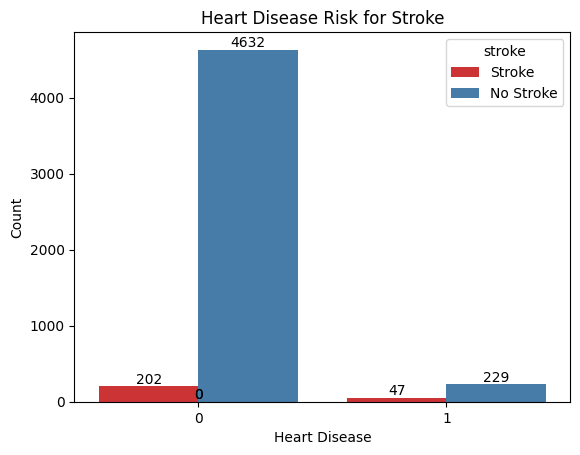

In [21]:
plot = sns.countplot(data=df_viz, x='heart_disease', hue='stroke', palette=cs)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 5), 
                  textcoords='offset points',) 

plot.set_title('Heart Disease Risk for Stroke')
plot.set_xlabel('Heart Disease')
plot.set_ylabel('Count')

### Gender Risk for Stroke

Text(0, 0.5, 'Count')

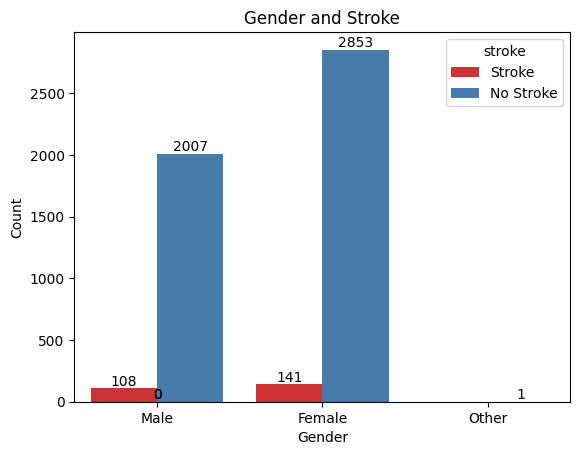

In [22]:
plot = sns.countplot(data=df_viz, x='gender', hue='stroke', palette=cs)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 5), 
                  textcoords='offset points',) 

plot.set_title('Gender and Stroke')
plot.set_xlabel('Gender')
plot.set_ylabel('Count')

### Hypertension Risk for Stroke

Text(0, 0.5, 'Count')

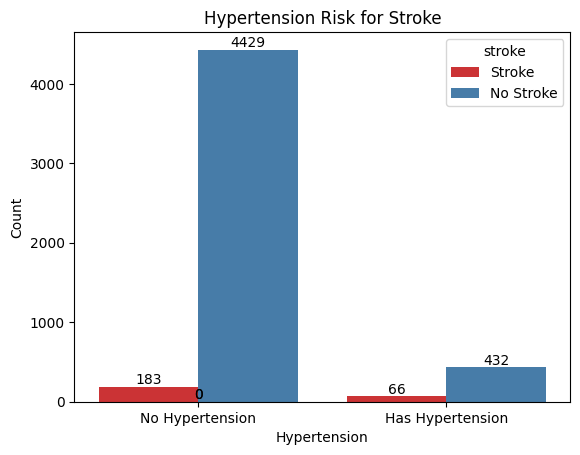

In [23]:
df_viz['hypertension'] = df_viz['hypertension'].map({0: 'No Hypertension', 1: 'Has Hypertension'})
plot = sns.countplot(data=df_viz, x='hypertension', hue='stroke', palette=cs)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 5), 
                  textcoords='offset points',) 

plot.set_title('Hypertension Risk for Stroke')
plot.set_xlabel('Hypertension')
plot.set_ylabel('Count')

### Marriage and Stroke

Text(0, 0.5, 'Count')

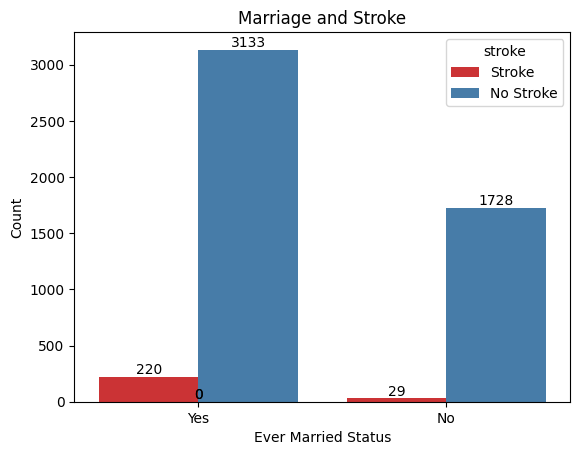

In [24]:
plot = sns.countplot(data=df_viz, x='ever_married', hue='stroke', palette=cs)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 5), 
                  textcoords='offset points',) 

plot.set_title('Marriage and Stroke')
plot.set_xlabel('Ever Married Status')
plot.set_ylabel('Count')

### Residence Location and Stroke

Text(0, 0.5, 'Count')

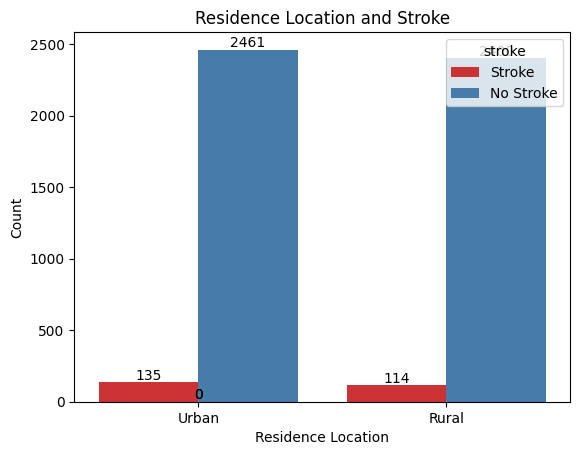

In [25]:
plot = sns.countplot(data=df_viz, x='Residence_type', hue='stroke', palette=cs)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 5), 
                  textcoords='offset points',) 

plot.set_title('Residence Location and Stroke')
plot.set_xlabel('Residence Location')
plot.set_ylabel('Count')

### Smoking risk for Stroke

Text(0, 0.5, 'Count')

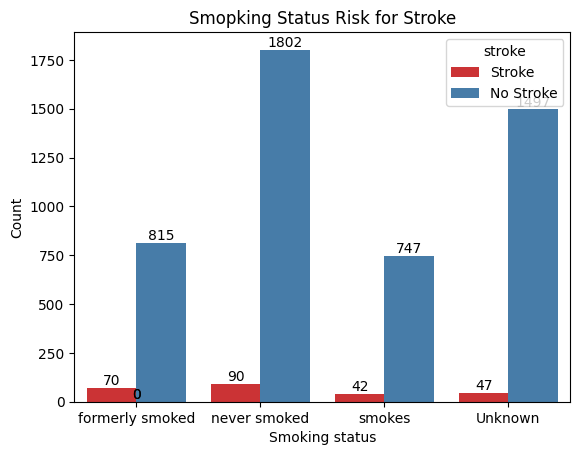

In [26]:
plot = sns.countplot(data=df_viz, x='smoking_status', hue='stroke', palette=cs)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 5), 
                  textcoords='offset points') 

plot.set_title('Smopking Status Risk for Stroke')
plot.set_xlabel('Smoking status')
plot.set_ylabel('Count')

Text(0, 0.5, 'Count')

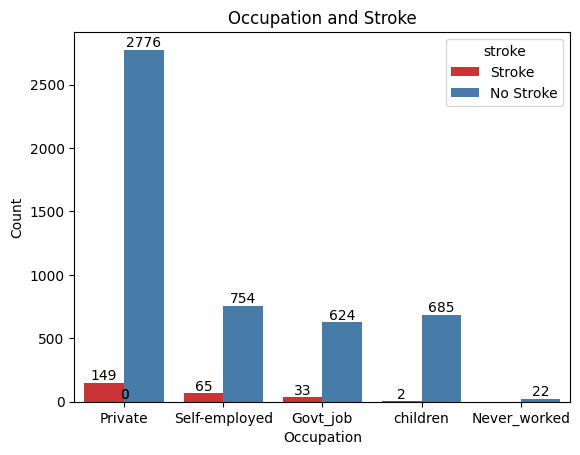

In [27]:
plot = sns.countplot(data=df_viz, x='work_type', hue='stroke', palette=cs)

for p in plot.patches:
    plot.annotate(f'{p.get_height():.0f}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 5), 
                  textcoords='offset points',) 

plot.set_title('Occupation and Stroke')
plot.set_xlabel('Occupation')
plot.set_ylabel('Count')

# Feature Engineering

### ID Significance

In [28]:
x = data['id']
y = data['stroke']
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 stroke   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1149
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.735
Time:                        11:37:13   Log-Likelihood:                 888.89
No. Observations:                4909   AIC:                            -1774.
Df Residuals:                    4907   BIC:                            -1761.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0408      0.006      6.985      0.000       0.029       0.052
id          4.654e-08   1.37e-07      0.339      0.735   -2.23e-07    3.16e-07
==============================================================================
Omnibus:                     4370.065   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            87041.978
Skew:                           4.531   Prob(JB):                         0.00
Kurtosis:                      21.532   Cond. No.                     8.64e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
feat_data = data.drop(columns='id')

### Correlation Matrix

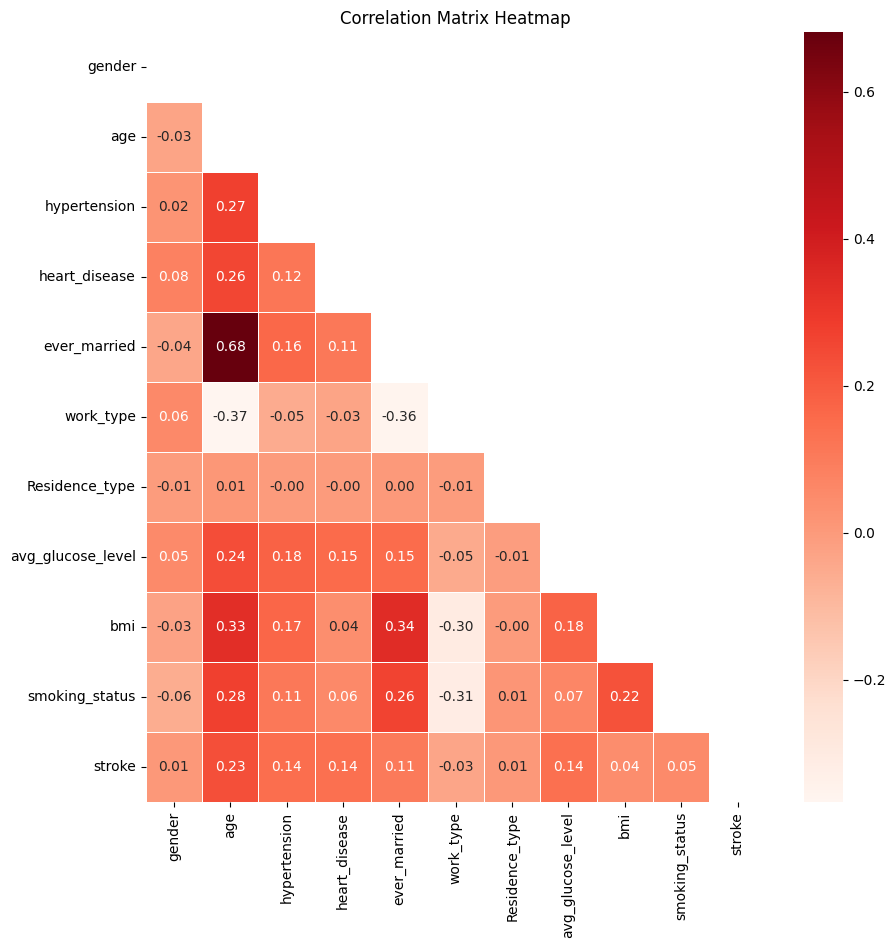

In [30]:
label_encoder = LabelEncoder()

df_encoded = feat_data.apply(lambda x: label_encoder.fit_transform(x) if x.dtype == 'object' else x)

cov_matrix = df_encoded.corr()
mask = np.triu(np.ones_like(cov_matrix, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(cov_matrix, mask = mask, annot=True, cmap='Reds', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Feature Clustering

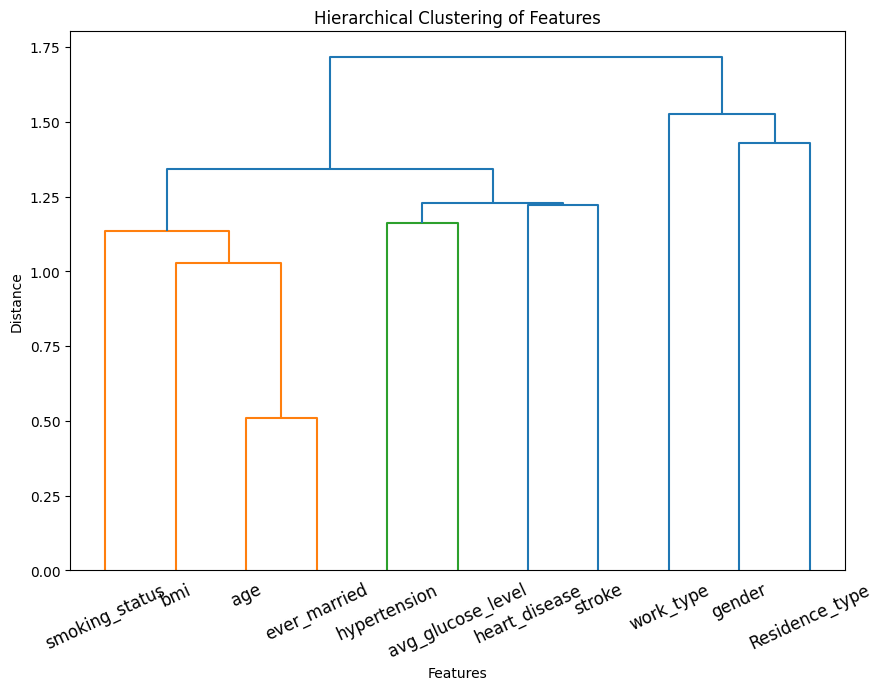

In [31]:
dist_matrix = 1 - cov_matrix

linked = linkage(dist_matrix, method='average')

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=cov_matrix.columns, leaf_rotation=25)
plt.title('Hierarchical Clustering of Features')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.show()

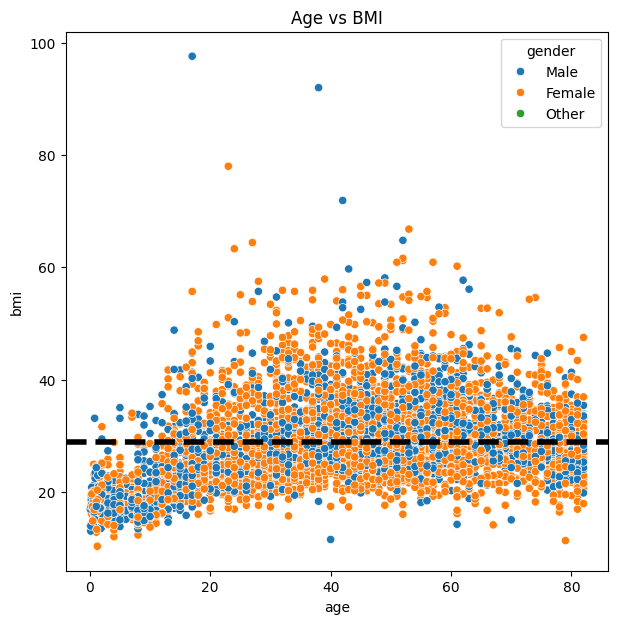

In [32]:
fig = plt.figure(figsize=(7,7))
graph = sns.scatterplot(data=data, x="age", y="bmi", hue='gender')
avg_bmi = data['bmi'].mean()
graph.axhline(y= avg_bmi, linewidth=4, color='black', linestyle= '--')
plt.title('Age vs BMI')
plt.show()

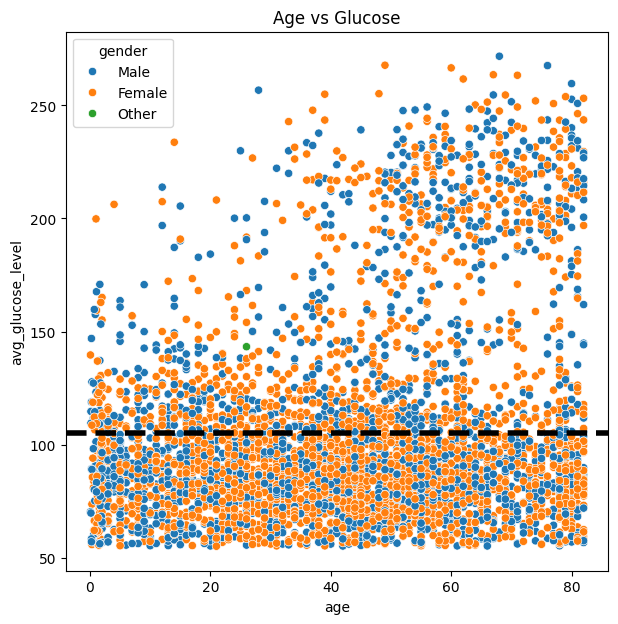

In [33]:
fig = plt.figure(figsize=(7,7))
graph = sns.scatterplot(data=data, x="age", y="avg_glucose_level", hue='gender')
avg_glc_lvl = data['avg_glucose_level'].mean()
graph.axhline(y= avg_glc_lvl, linewidth=4, color='black', linestyle= '--')
plt.title('Age vs Glucose')
plt.show()

### Data Pre-Processing

In [34]:
df = data.copy()
df = df.drop(columns='id')

categorical_features = df.select_dtypes(include='object')

### Chi-square test

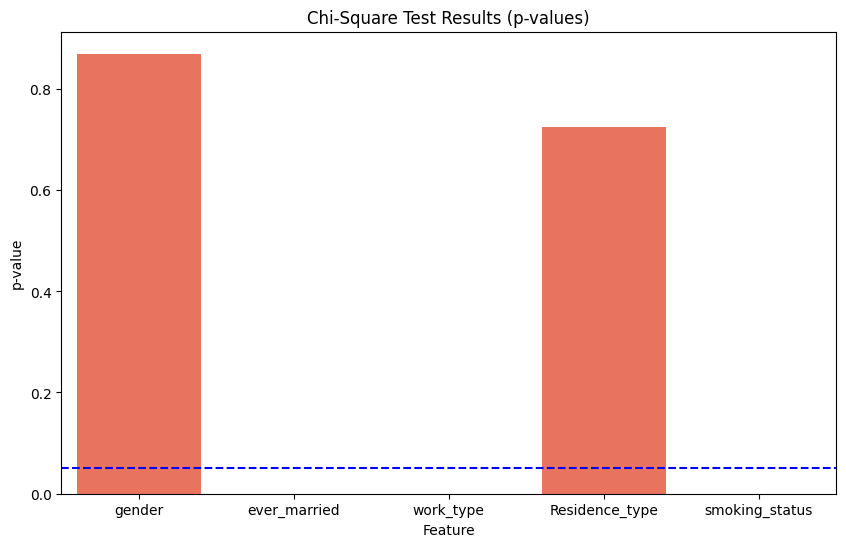

In [35]:
chi_square_results = {}

for col in categorical_features:
    contingency_table = pd.crosstab(df[col], y)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi_square_results[col] = p

df_chi_square = pd.DataFrame(list(chi_square_results.items()), columns=['Feature', 'p-value'])

plt.figure(figsize=(10, 6))
sns.barplot(data=df_chi_square, x='Feature', y='p-value', color = 'tomato')
plt.axhline(0.05, color='blue', linestyle='--', label='p = 0.05')
plt.title('Chi-Square Test Results (p-values)')
plt.ylabel('p-value')

plt.show()



### ANOVA test

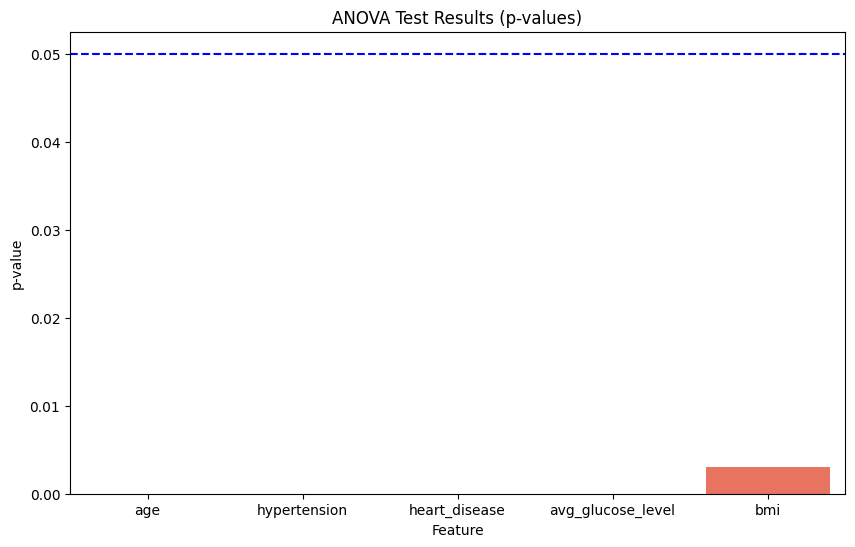

In [36]:
anova_results = {}
num_features = df.select_dtypes(exclude='object')
num_features = num_features.drop(columns='stroke')

for col in num_features:
    group_0 = df[y == 0][col]
    group_1 = df[y == 1][col]
    f_stat, p_value = f_oneway(group_0, group_1)
    anova_results[col] = p_value


anova_graph = pd.DataFrame(list(anova_results.items()), columns=['Feature', 'p-value'])

plt.figure(figsize=(10, 6))
sns.barplot(data=anova_graph, x='Feature', y='p-value', color = 'tomato')
plt.axhline(0.05, color='blue', linestyle='--', label='p = 0.05')
plt.title('ANOVA Test Results (p-values)')
plt.ylabel('p-value')

plt.show()

### PCA Analysis

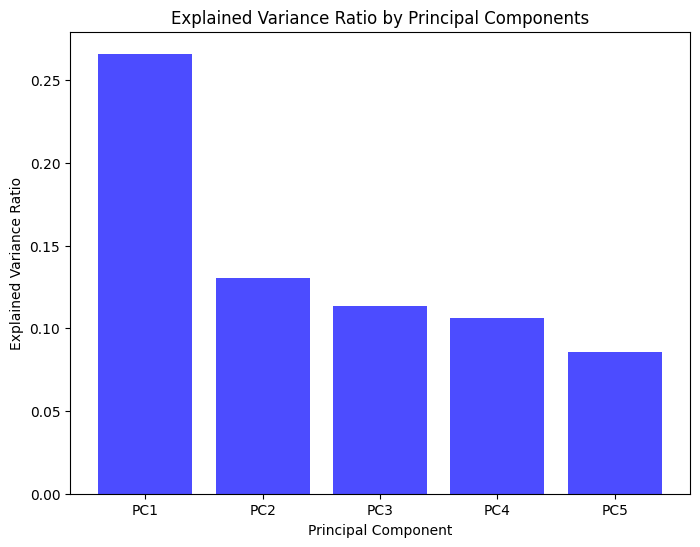

Explained variance ratio: [0.26601215 0.13067098 0.11344779 0.10617729 0.08558099]

Features associated with each principal component:

Principal Component 1:
Feature: age, Loading: 0.5796937098623407
Feature: hypertension, Loading: 0.35827480539292417
Feature: heart_disease, Loading: 0.27976841311804396
Feature: avg_glucose_level, Loading: 0.34541082569091086
Feature: bmi, Loading: 0.4254124317451548
Feature: gender_Female, Loading: -0.00031606834615110097
Feature: gender_Male, Loading: 0.0004006154270618268
Feature: gender_Other, Loading: -8.454708091072607e-05
Feature: ever_married_No, Loading: -0.22156272137648655
Feature: ever_married_Yes, Loading: 0.22156272137648655
Feature: work_type_Govt_job, Loading: 0.02642420243728079
Feature: work_type_Never_worked, Loading: -0.0031363858717894646
Feature: work_type_Private, Loading: 0.05944974178513048
Feature: work_type_Self-employed, Loading: 0.06612193714362595
Feature: work_type_children, Loading: -0.14885949549424776
Feature: Residen

In [37]:
numerical_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Create a column transformer
ct = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(), categorical_cols)
])

df_transformed_tmp = ct.fit_transform(df)

feature_names = numerical_cols + list(ct.named_transformers_['cat'].get_feature_names_out(categorical_cols))

pca = PCA(n_components=5)
pca.fit(df_transformed_tmp)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, color='b')

plt.xticks(range(1, len(explained_variance_ratio) + 1), [f'PC{i}' for i in range(1, len(explained_variance_ratio) + 1)])

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Components')

plt.show()

print("Explained variance ratio:", explained_variance_ratio)

print("\nFeatures associated with each principal component:")
for i, component in enumerate(pca.components_):
    print(f"\nPrincipal Component {i + 1}:")
    for feature, loading in zip(feature_names, component):
        print(f"Feature: {feature}, Loading: {loading}")

### Data Pre-Processing

In [38]:
df = df.drop(columns=['gender', 'Residence_type'])

X = df.drop(columns= 'stroke')
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = df.select_dtypes(include='object')
num_features = df.select_dtypes(exclude='object')
num_features = num_features.drop(columns='stroke')

column_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_features.columns),  
    ('num', StandardScaler(), num_features.columns)   
])
x_train_trans = column_transformer.fit_transform(X_train)
x_test_trans = column_transformer.fit_transform(X_test)

# Predictive Modeling

### Random Forest & Cross Fold

In [39]:
rf_model = RandomForestClassifier(random_state=14)
rf_model.fit(x_train_trans, y_train)

y_pred_rf = rf_model.predict(x_test_trans)

accuracy = accuracy_score(y_test, y_pred_rf)
classification_rep = classification_report(y_test, y_pred_rf)

cv_results_rf = cross_validate(rf_model, x_train_trans, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

mean_accuracy = np.mean(cv_results_rf['test_accuracy'])
std_accuracy = np.std(cv_results_rf['test_accuracy'])

print(f"Random Forest CV Mean accuracy: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

print(f"Accuracy: {accuracy:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_rep)


Random Forest CV Mean accuracy: 0.9587
Standard deviation of accuracy: 0.0013
Accuracy: 0.9460

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982



### XGBoost & Cross Fold

In [40]:
xgb_model = XGBClassifier(random_state=14, use_label_encoder=False, eval_metric='logloss')

xgb_model.fit(x_train_trans, y_train)

y_pred_xgb = xgb_model.predict(x_test_trans)

accuracy = accuracy_score(y_test, y_pred_xgb)
classification_rep = classification_report(y_test, y_pred_xgb)

cv_results_xgb = cross_validate(xgb_model, x_train_trans, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

mean_accuracy = np.mean(cv_results_xgb['test_accuracy'])
std_accuracy = np.std(cv_results_xgb['test_accuracy'])

print(f"XGBoost CV Mean accuracy: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

print(f"Accuracy: {accuracy:.4f}")
print("\nXGBoost Classification Report:")
print(classification_rep)

XGBoost CV Mean accuracy: 0.9526
Standard deviation of accuracy: 0.0032
Accuracy: 0.9389

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       929
           1       0.11      0.02      0.03        53

    accuracy                           0.94       982
   macro avg       0.53      0.51      0.50       982
weighted avg       0.90      0.94      0.92       982



### KNN Model & Cross-Fold

In [41]:
X_train_pca = pca.fit_transform(x_train_trans)
X_test_pca = pca.transform(x_test_trans)

knn_model = KNeighborsClassifier()

knn_model.fit(X_train_pca, y_train)

y_pred_knn = knn_model.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred_knn)
classification_rep = classification_report(y_test, y_pred_knn)

cv_results_knn = cross_validate(xgb_model, x_train_trans, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])

mean_accuracy = np.mean(cv_results_knn['test_accuracy'])
std_accuracy = np.std(cv_results_knn['test_accuracy'])

print(f"KNN CV Mean accuracy: {mean_accuracy:.4f}")
print(f"Standard deviation of accuracy: {std_accuracy:.4f}")

print(f"Accuracy: {accuracy:.4f}")
print("\nKNN Classification Report:")
print(classification_rep)

KNN CV Mean accuracy: 0.9526
Standard deviation of accuracy: 0.0032
Accuracy: 0.9420

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       929
           1       0.17      0.02      0.03        53

    accuracy                           0.94       982
   macro avg       0.56      0.51      0.50       982
weighted avg       0.90      0.94      0.92       982



### Model Performances

In [42]:
metrics = {
    'Metric': ['Precision', 'Accuracy', 'Recall', 'F1 Score'],
    'KNN': [
        precision_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_knn),
        recall_score(y_test, y_pred_knn),
        f1_score(y_test, y_pred_knn)
    ],
    'XGBoost': [
        precision_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_xgb),
        recall_score(y_test, y_pred_xgb),
        f1_score(y_test, y_pred_xgb)
    ],
    'Random Forest': [
        precision_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf)
    ]
}

# Create a DataFrame to display the results
results_df = pd.DataFrame(metrics)
results_df

,Metric,KNN,XGBoost,Random Forest
0,Precision,0.166667,0.111111,0.000000
1,Accuracy,0.941955,0.938900,0.946029
2,Recall,0.018868,0.018868,0.000000
3,F1 Score,0.033898,0.032258,0.000000


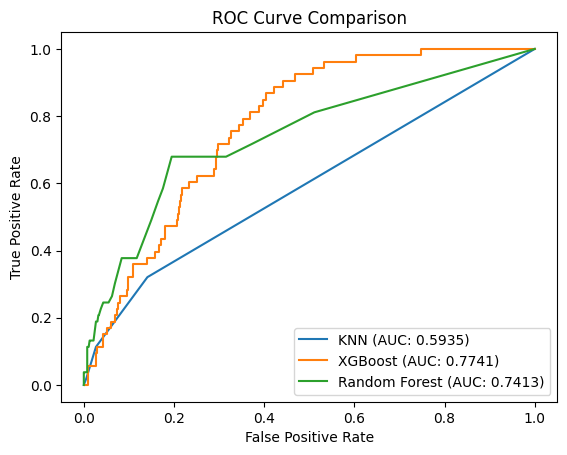

In [43]:
y_prob_knn = knn_model.predict_proba(X_test_pca)[:, 1]
y_prob_xgb = xgb_model.predict_proba(x_test_trans)[:, 1]
y_prob_rf = rf_model.predict_proba(x_test_trans)[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

auc_knn = roc_auc_score(y_test, y_prob_knn)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure()
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC: {auc_knn:.4f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC: {auc_xgb:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC: {auc_rf:.4f})')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()